### Import Libraries


In [1]:
import sys
import pathlib
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
from ccc.coef import ccc

sys.path.append("../utils")
from split_utils import get_features_data


### Load Labeled Data


In [2]:
# load labeled data
labeled_data_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
labeled_data = get_features_data(labeled_data_path)
#labeled_data

### Creat esingle class model interpretations


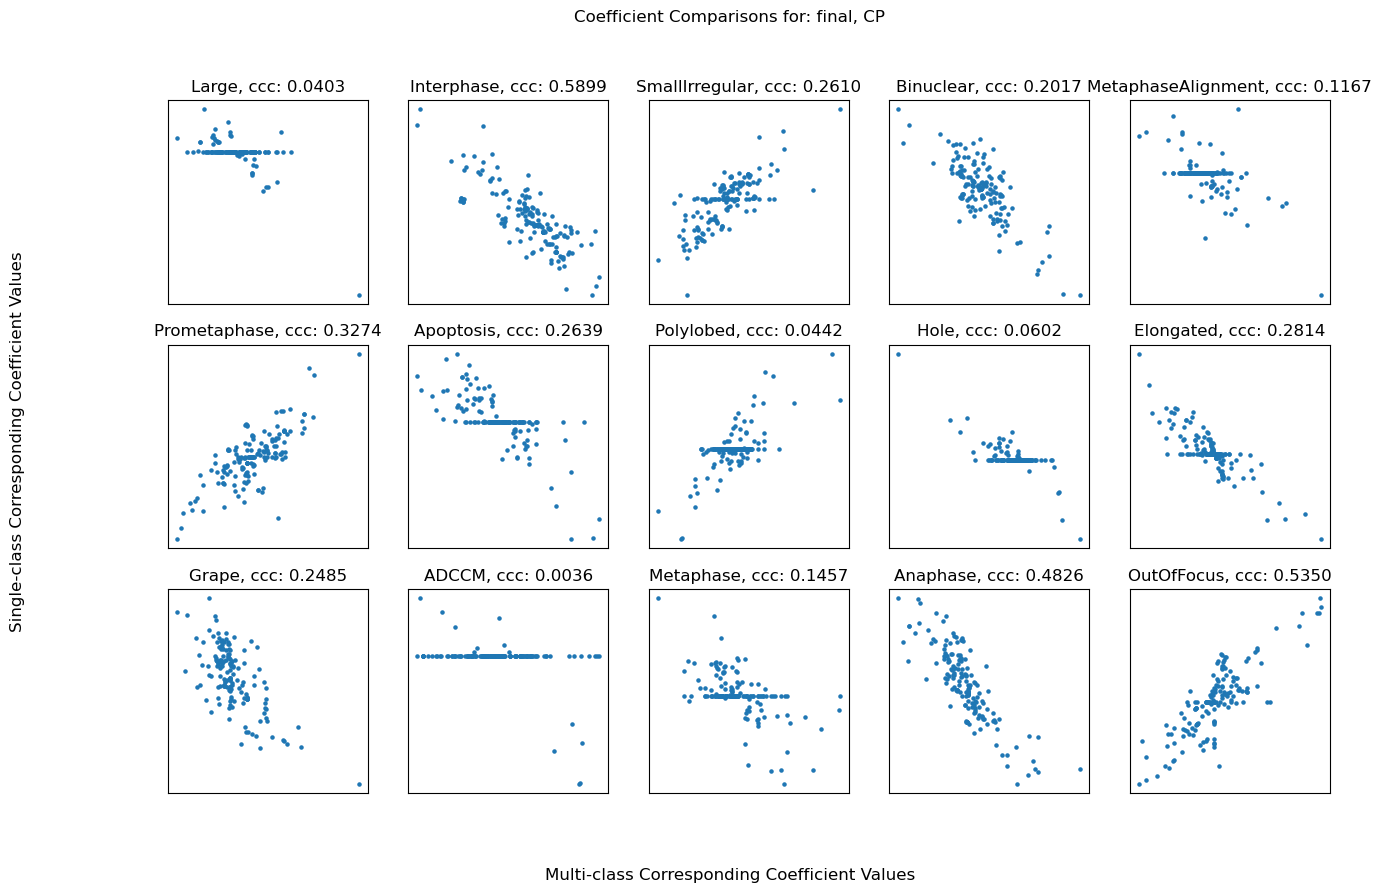

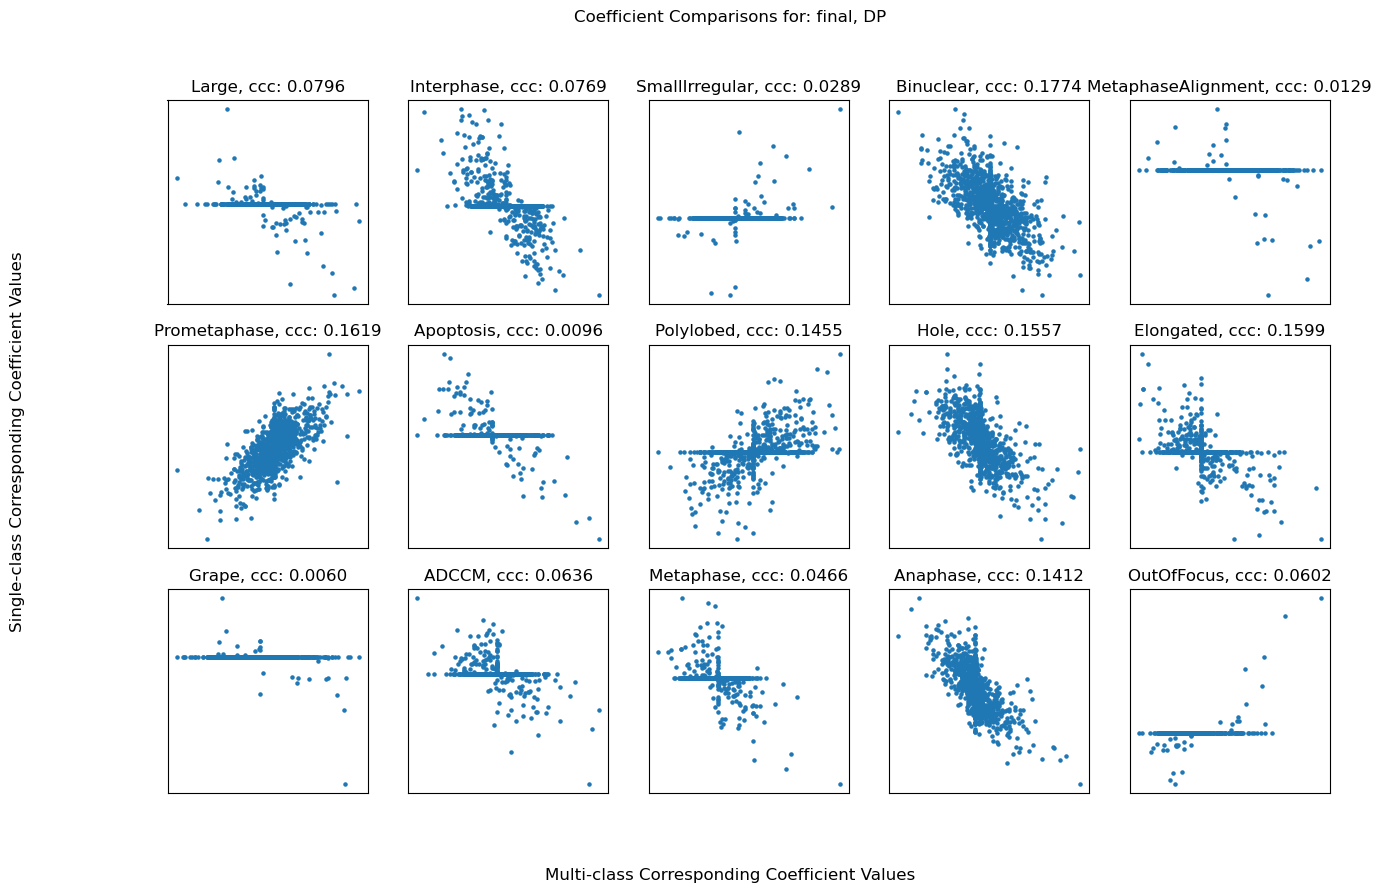

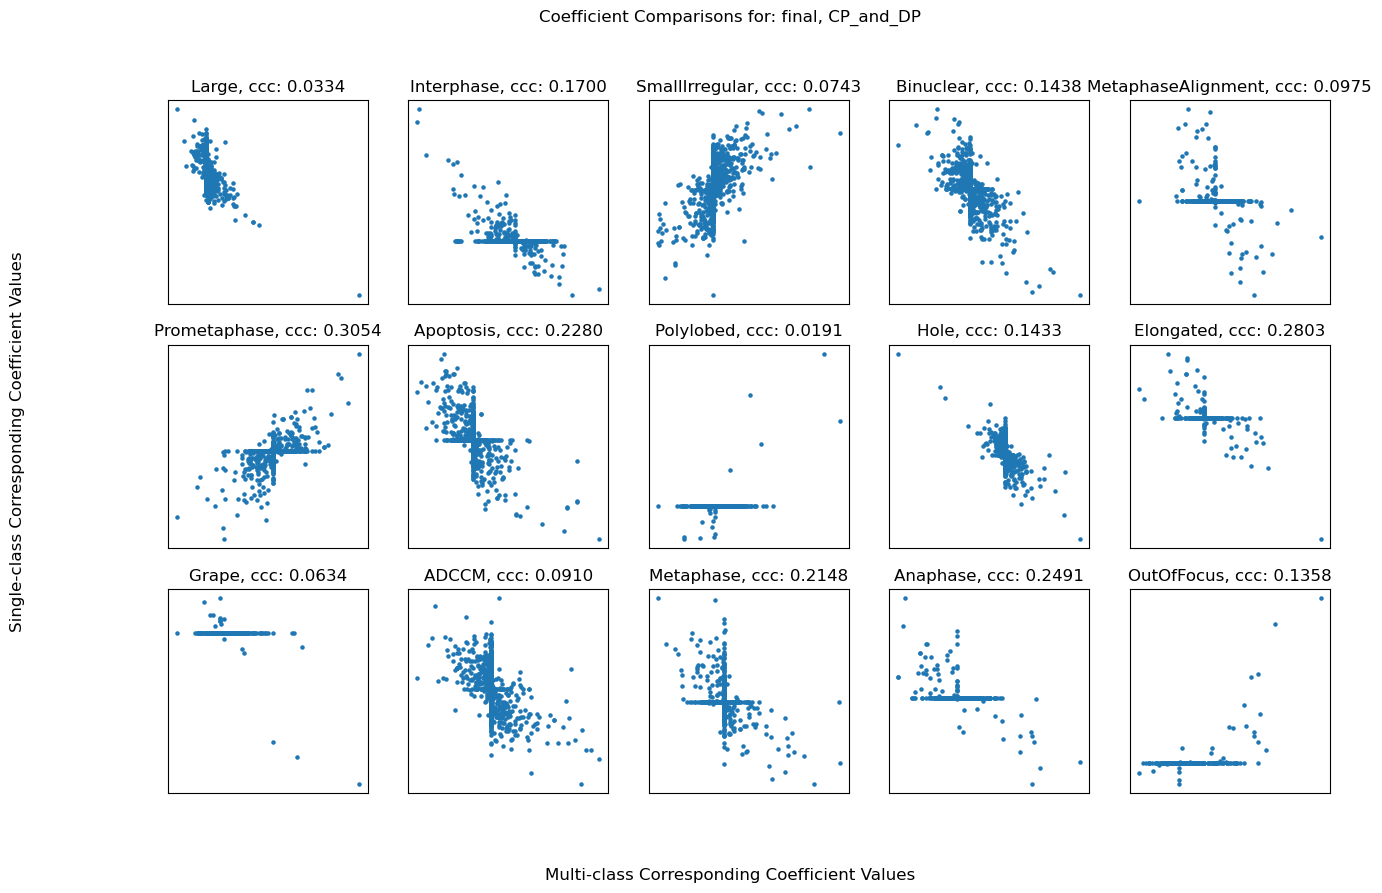

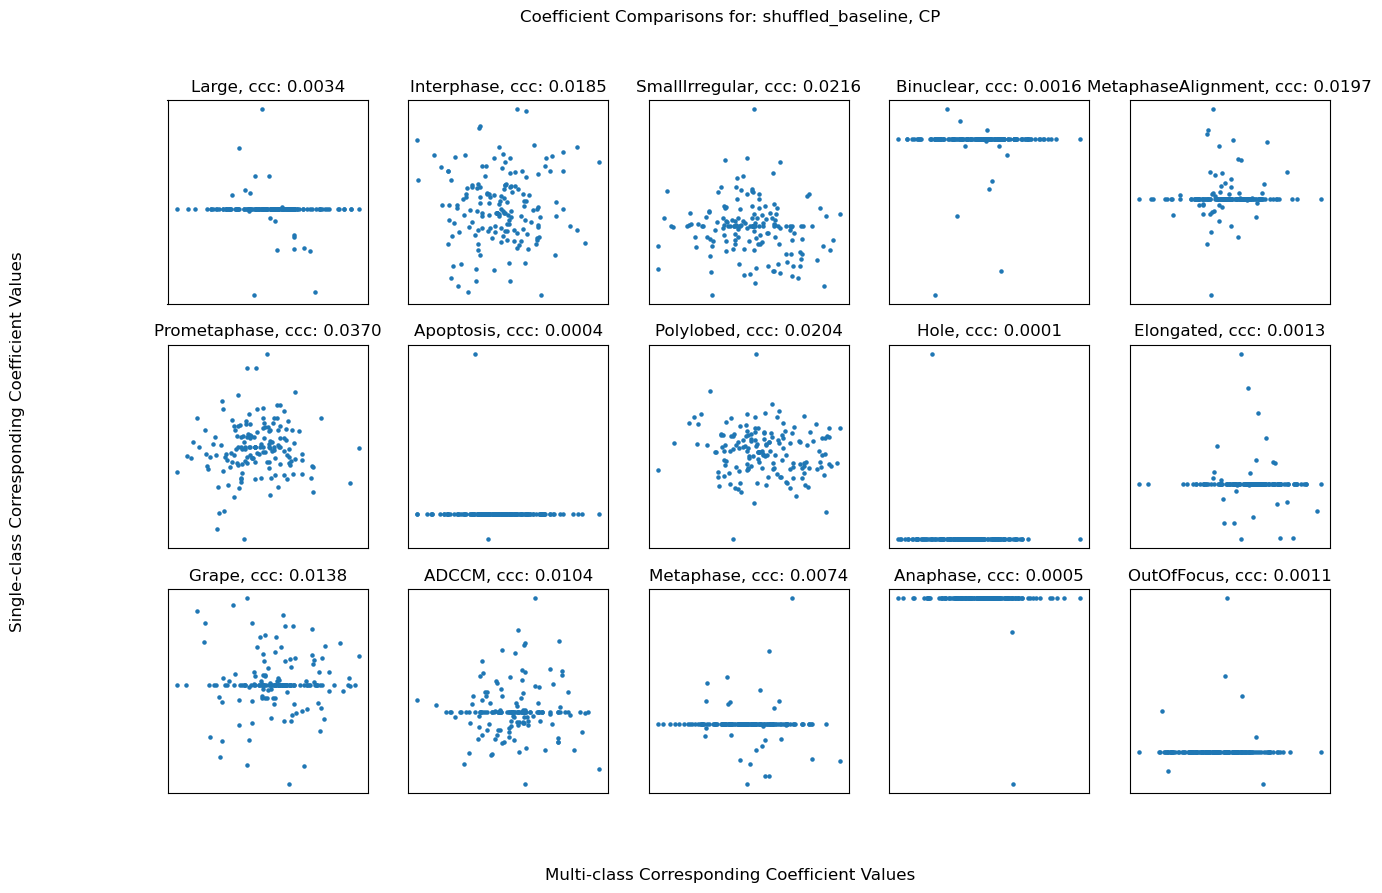

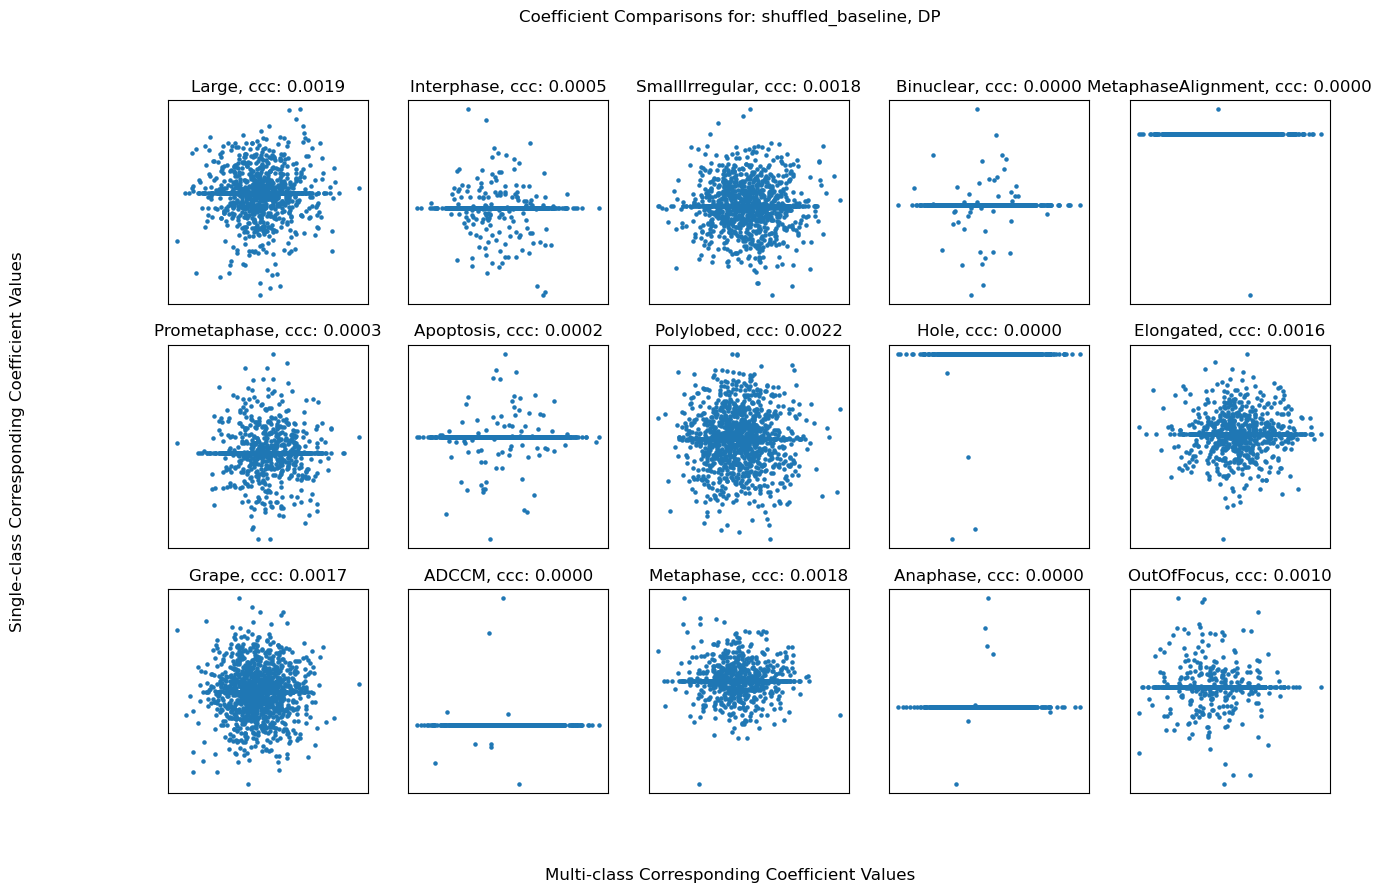

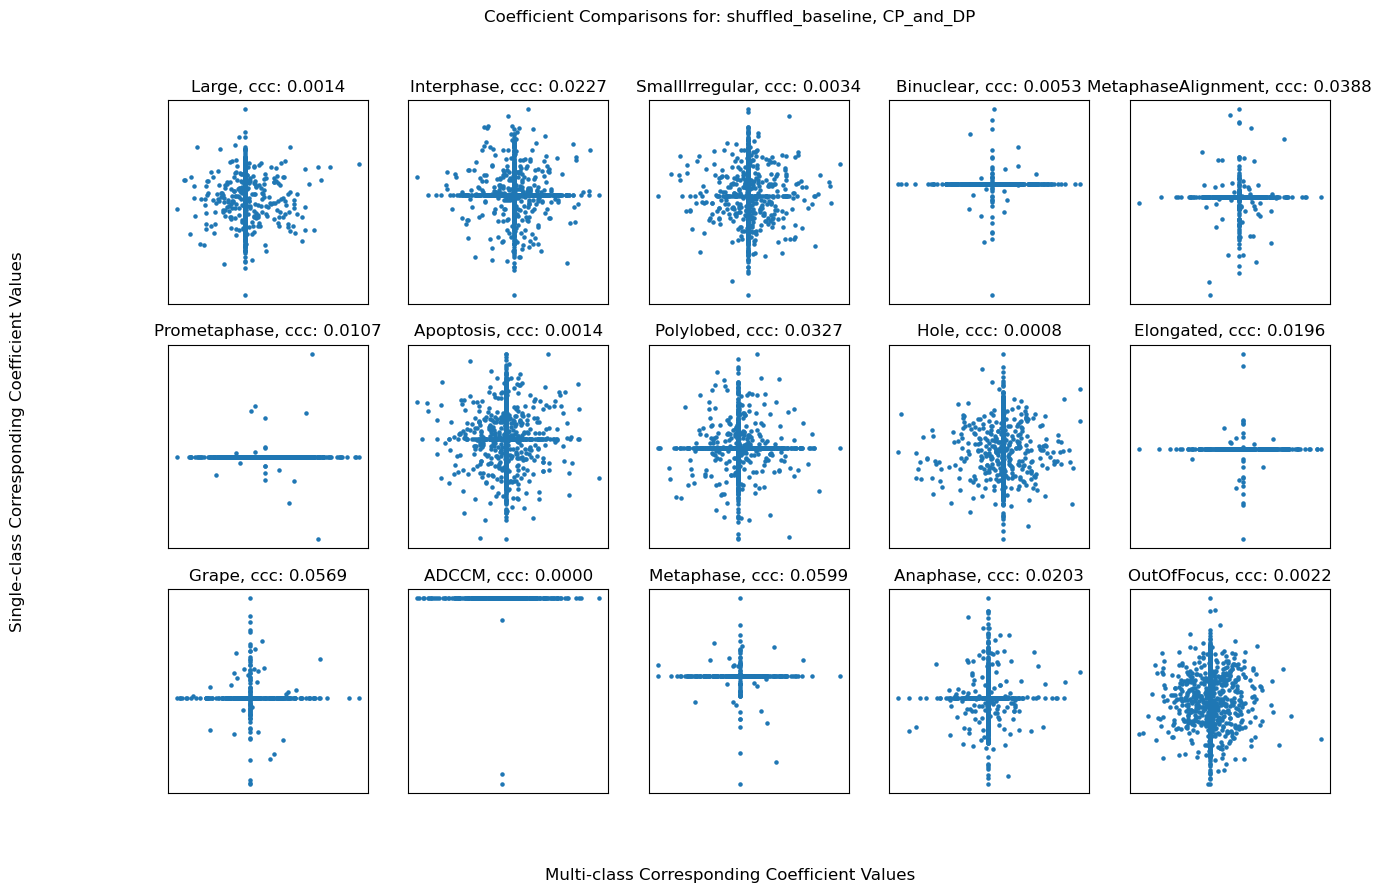

In [3]:
# directories to load the models from
multi_class_models_dir = pathlib.Path("../2.train_model/models/multi_class_models/")
single_class_models_dir = pathlib.Path("../2.train_model/models/single_class_models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_coefficients = []

# define combinations to test over
model_types = ["final", "shuffled_baseline"]
feature_types = ["CP", "DP", "CP_and_DP"]
phenotypic_classes = labeled_data["Mitocheck_Phenotypic_Class"].unique()

# iterate through each combination of feature_types, evaluation_types, phenotypic_classes
for model_type, feature_type in itertools.product(
    model_types, feature_types
):
    # create a figure that has 3x5 subplots for 15 phenotypic classes
    fig, axs = plt.subplots(3, 5)
    fig.set_size_inches(15, 9)
    # variables to keep track of figure subplot coordinates
    ax_x = 0
    ax_y = 0
    
    # get multi class model coefficients for this combination of model type, feature type
    multi_class_model_path = pathlib.Path(
        f"{multi_class_models_dir}/{model_type}__{feature_type}.joblib"
    )
    multi_class_model = load(multi_class_model_path)
    multi_class_coeffs = pd.DataFrame(multi_class_model.coef_).T
    multi_class_coeffs.columns = multi_class_model.classes_
    
    # get multi class model coefficients for this combination of model type, feature type
    for phenotypic_class in phenotypic_classes:
        # load single class model for this combination of model type, feature type
        single_class_model_path = pathlib.Path(
            f"{single_class_models_dir}/{phenotypic_class}_models/{model_type}__{feature_type}.joblib"
        )
        single_class_model = load(single_class_model_path)
        
        # get model coefficients
        single_class_specific_coefs = pd.DataFrame(single_class_model.coef_).T
        single_class_specific_coefs.columns = [phenotypic_class]
        
        # plot scatter subplot for this phenotypic class
        scatter_x = multi_class_coeffs[phenotypic_class]
        scatter_y = single_class_specific_coefs[phenotypic_class]        
        axs[ax_x, ax_y].scatter(scatter_x, scatter_y, s=5)
        # turn off ticks for axes
        axs[ax_x, ax_y].set_xticks([])
        axs[ax_x, ax_y].set_yticks([])
        
        # get clustermap correlation coefficient (ccc)
        correlation = ccc(scatter_x, scatter_y)
        correlation_string = "{:.4f}".format(correlation)
        # label graph with phenotypic class and ccc
        axs[ax_x, ax_y].set_title(f"{phenotypic_class}, ccc: {correlation_string}")
        
        # increase row coordinate counter (this marks which subplot to plot on in vertical direction)
        ax_x += 1
        # if row coordinate counter is at maximum (3 rows of subplots)
        if ax_x == 3:
            # set row coordinate counter to 0
            ax_x = 0
            # increase column coordinate counter (this marks which subplot to plot on in horizontal direction)
            ax_y += 1
    
    # add title and axes labels to figure
    fig.suptitle(
        f"Coefficient Comparisons for: {model_type}, {feature_type}"
    )
    fig.supxlabel("Multi-class Corresponding Coefficient Values")
    fig.supylabel("Single-class Corresponding Coefficient Values")
    plt.plot()